In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import utils
import pandas as pd
import gc
import mlrose_hiive as mlrose

from mlrose_hiive.algorithms.decay import ExpDecay
from mlrose_hiive.neural import NeuralNetwork

from sklearn.metrics import log_loss, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    END = '\033[0m'

In [9]:
#stratified sampling in sklearn
def stratified_sampling(vegito, target, size = 0.4, seed = 903949505):
    gc.collect()
    goku, vegita = train_test_split(vegito, test_size=size, stratify=vegito[target], random_state=seed)
    print(color.BOLD + color.UNDERLINE + color.DARKCYAN + "Original distribution" + color.END)
    c = vegito[target].value_counts(normalize=False)
    p = vegito[target].value_counts(normalize=True)*100
    display(pd.concat([c,p], axis=1, keys=['counts', '%']))
    print("\n" + "\n" + color.BOLD + color.UNDERLINE + color.WARNING + "Train distribution" + color.END)
    c = goku[target].value_counts(normalize=False)
    p = goku[target].value_counts(normalize=True)*100
    display(pd.concat([c,p], axis=1, keys=['counts', '%']))
    print("\n" + "\n" + color.BOLD + color.UNDERLINE + color.RED + "Test distribution" + color.END)
    c = vegita[target].value_counts(normalize=False)
    p = vegita[target].value_counts(normalize=True)*100
    display(pd.concat([c,p], axis=1, keys=['counts', '%']))
    
    #split goku, vegita and cell by target variable to make depent and indepent data seperately
    goku_X = goku.drop(target, axis=1)
    vegita_X = vegita.drop(target, axis=1)
    goku_y = pd.DataFrame(goku[target])
    vegita_y = pd.DataFrame(vegita[target])
    
    #return goku_X, goku_y, vegita_X, vegita_y
    print("\n" + "\n" + color.BOLD + color.UNDERLINE + color.BLUE + "Train_x shape" + color.END)
    print("Number of columns are " + color.BOLD + str(goku_X.shape[0]) + color.END + " and number of rows are " + color.BOLD + str(goku_X.shape[1]) + color.END)
    display(goku_X.head())
    print("\n" + "\n" + color.BOLD + color.UNDERLINE + color.BLUE + "Train_y shape" + color.END)
    print("Number of columns are " + color.BOLD + str(goku_y.shape[0]) + color.END + " and number of rows are " + color.BOLD + str(goku_y.shape[1]) + color.END)
    display(goku_y.head())
    print("\n" + "\n" + color.BOLD + color.UNDERLINE + color.BLUE + "Train_x shape" + color.END)
    print("Number of columns are " + color.BOLD + str(vegita_X.shape[0]) + color.END + " and number of rows are " + color.BOLD + str(vegita_X.shape[1]) + color.END)
    display(vegita_X.head())
    print("\n" + "\n" + color.BOLD + color.UNDERLINE + color.BLUE + "Train_y shape" + color.END)
    print("Number of columns are " + color.BOLD + str(vegita_y.shape[0]) + color.END + " and number of rows are " + color.BOLD + str(vegita_y.shape[1]) + color.END)
    display(vegita_y.head())
    return goku_X, goku_y, vegita_X, vegita_y

In [3]:
def plot_nn_perf(trainX, testX, trainY, testY, random_seeds, **kwargs):
    
    gc.collect()
    # Initialize algorithms, corresponding acronyms and max number of iterations
    algorithms = ['random_hill_climb', 'simulated_annealing', 'genetic_alg', 'gradient_descent']
    max_iters = ['rhc_max_iters', 'sa_max_iters', 'ga_max_iters', 'gd_max_iters']

    # Define SA exponential decay schedule
    exp_decay = ExpDecay(init_temp=kwargs['init_temp'],
                         exp_const=kwargs['exp_decay_rate'],
                         min_temp=kwargs['min_temp'])

    Output = pd.DataFrame(columns=['i', 'algorithm', 'random_seed', 'Itterations', 'train_accuracy', 'val_acccuracy', 'train_times', 'test_accuracy', 'test_F1'])
    
    # For each of the optimization algorithms to test the Neural Network with
    for i, algorithm in enumerate(algorithms):
        gc.collect()
        print('\nAlgorithm = {}'.format(algorithm))

        # Initialize training losses, validation losses and training time lists for current random run
        for random_seed in random_seeds:
            
            gc.collect()
            # Compute stratified k-fold
            x_train_fold, x_val_fold, y_train_fold, y_val_fold = train_test_split(trainX, trainY, test_size=0.2, shuffle=False,random_state=random_seed, stratify=trainY)
            
            # For each max iterations to run for
            for max_iter in kwargs[max_iters[i]]:

                # Define Neural Network using current algorithm
                nn = NeuralNetwork(hidden_nodes=[32,], activation='relu',
                                   algorithm=algorithm, max_iters=int(max_iter),
                                   bias=True, is_classifier=True, learning_rate=0.001,
                                   early_stopping=False, clip_max=1e10, schedule=exp_decay,
                                   pop_size=kwargs['pop_size'], mutation_prob=kwargs['mutation_prob'],
                                   max_attempts=int(max_iter), random_state=random_seed, curve=True)

                # Train on current training fold and append training time
                start_time = time.time()
                nn.fit(x_train_fold, y_train_fold)
                train_times = time.time() - start_time
                
                # Compute and append training and validation log losses
                train_accuracy = accuracy_score(y_train_fold, pd.DataFrame(nn.predict(x_train_fold), index=y_train_fold.index))
                val_acccuracy = accuracy_score(y_val_fold, pd.DataFrame(nn.predict(x_val_fold), index=y_val_fold.index))
                test_acccuracy = accuracy_score(testY, pd.DataFrame(nn.predict(testX), index=testY.index))
                test_f1_score = f1_score(testY, pd.DataFrame(nn.predict(testX), index=testY.index))
                
                print('{} - train loss = {:.3f}, val loss = {:.3f}'.format(max_iter, train_accuracy, val_acccuracy))
                Output = Output.append({'i' : i, 'algorithm' : algorithm, 'random_seed' : random_seed, 'Itterations' : max_iter, 'train_accuracy' : train_accuracy, 'val_acccuracy' : val_acccuracy, 'train_times' : train_times, 'test_accuracy' : test_acccuracy, 'test_F1' : test_f1_score}, ignore_index=True)
            display(Output)
                
    return Output
        

In [8]:
def neural_network(trainX, testX, trainY, testY):
    # Maximum iterations to run the Neural Network for
#     iterations = np.arange(1000, 10001, 1000)
    iterations = np.arange(5, 301, 5)
#     random_seeds = np.array([7, 123, 10000, 99999])
    random_seeds = np.array([7, 123, 10000])

    # Plot performances for RHC, SA, GA and GD with Neural Networks
    Output = plot_nn_perf(trainX, testX, trainY, testY,
                            random_seeds=random_seeds,
                            rhc_max_iters=iterations, sa_max_iters=iterations,
                            ga_max_iters=iterations, gd_max_iters=iterations,
                            init_temp=100, exp_decay_rate=0.1, min_temp=0.001,
                            pop_size=100, mutation_prob=0.2)
    return Output

In [5]:
# data = pd.read_csv("C:/Users/sagni/Documents/Personal Files/CS7641/CS7641/Data/Bank_churn/train.csv", index_col=0)
# data.drop(['Surname','CustomerId'], axis=1, inplace=True)
# data['HasCrCard'] = data['HasCrCard'].astype(int)
# data['Age'] = data['Age'].astype(int)
# data['IsActiveMember'] = data['IsActiveMember'].astype(int)
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import make_column_transformer
# transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),['Geography','Gender']))
# # Transforming
# transformed = transformer.fit_transform(data.drop(['Exited'], axis=1))
# print(transformed.dtype)
# # Transformating back
# transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names())
# # One-hot encoding removed an index. Let's put it back:
# transformed_df.index = data.index
# # Joining tables
# data = pd.concat([data, transformed_df], axis=1)
# # Dropping old categorical columns
# data.drop(['Geography','Gender'], axis=1, inplace=True)
# # CHecking result
# data.head()
# trainX, trainY, testX, testY = stratified_sampling(data, 'Exited', 0.9, 903949505)

# # join testX and testY on index to create a daframe data
# data = pd.concat([testX, testY], axis=1)
# testX, testY, ignoreX, ignoreY = stratified_sampling(data, 'Exited', 0.5, 903949505)
# #delete pandas dataframe ignoreX, ignoreY
# del ignoreX
# del ignoreY
# del data

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(trainX)
# trainX = pd.DataFrame(scaler.transform(trainX), columns=trainX.columns, index=trainX.index)
# testX = pd.DataFrame(scaler.transform(testX), columns=testX.columns, index=testX.index)
# display(trainX.head())
# display(testX.head())

float64
Original distribution


,counts,%
0,130113,78.840118
1,34921,21.159882




Train distribution


,counts,%
0,13011,78.840211
1,3492,21.159789




Test distribution


,counts,%
0,117102,78.840107
1,31429,21.159893




Train_x shape
Number of columns are 16503 and number of rows are 13


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,onehotencoder__x0_France,onehotencoder__x0_Germany,onehotencoder__x0_Spain,onehotencoder__x1_Female,onehotencoder__x1_Male
id,,,,,,,,,,,,,
3638,669,32,7,0.00,2,1,0,93982.02,1.0,0.0,0.0,0.0,1.0
159233,672,29,9,0.00,2,1,1,134794.02,1.0,0.0,0.0,1.0,0.0
38435,644,32,2,0.00,2,1,0,103932.38,1.0,0.0,0.0,0.0,1.0
144063,724,24,7,142755.25,1,0,0,34231.48,0.0,1.0,0.0,0.0,1.0
52235,572,39,8,89047.74,1,1,1,178373.87,1.0,0.0,0.0,0.0,1.0




Train_y shape
Number of columns are 16503 and number of rows are 1


,Exited
id,
3638,0
159233,0
38435,0
144063,0
52235,0




Train_x shape
Number of columns are 148531 and number of rows are 13


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,onehotencoder__x0_France,onehotencoder__x0_Germany,onehotencoder__x0_Spain,onehotencoder__x1_Female,onehotencoder__x1_Male
id,,,,,,,,,,,,,
65509,632,31,7,111388.18,1,0,1,173498.45,0.0,1.0,0.0,1.0,0.0
20875,641,34,8,0.00,2,0,0,124615.59,1.0,0.0,0.0,0.0,1.0
53648,726,63,6,123948.85,1,0,0,145560.38,1.0,0.0,0.0,1.0,0.0
40310,671,29,3,105229.53,1,1,1,131804.86,0.0,0.0,1.0,0.0,1.0
60496,711,40,7,0.00,2,1,0,180829.87,0.0,0.0,1.0,0.0,1.0




Train_y shape
Number of columns are 148531 and number of rows are 1


,Exited
id,
65509,0
20875,0
53648,1
40310,0
60496,0


Original distribution


,counts,%
0,117102,78.840107
1,31429,21.159893




Train distribution


,counts,%
0,58551,78.840638
1,15714,21.159362




Test distribution


,counts,%
0,58551,78.839577
1,15715,21.160423




Train_x shape
Number of columns are 74265 and number of rows are 13


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,onehotencoder__x0_France,onehotencoder__x0_Germany,onehotencoder__x0_Spain,onehotencoder__x1_Female,onehotencoder__x1_Male
id,,,,,,,,,,,,,
121133,675,29,6,121063.57,2,0,1,102076.92,0.0,1.0,0.0,0.0,1.0
39290,569,33,3,153058.10,1,1,1,102625.08,0.0,1.0,0.0,1.0,0.0
156352,629,32,7,137781.65,1,0,1,153921.32,1.0,0.0,0.0,1.0,0.0
77927,721,31,3,0.00,2,1,0,121151.10,1.0,0.0,0.0,1.0,0.0
93794,642,33,2,0.00,2,1,0,131736.23,1.0,0.0,0.0,1.0,0.0




Train_y shape
Number of columns are 74265 and number of rows are 1


,Exited
id,
121133,0
39290,1
156352,0
77927,0
93794,0




Train_x shape
Number of columns are 74266 and number of rows are 13


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,onehotencoder__x0_France,onehotencoder__x0_Germany,onehotencoder__x0_Spain,onehotencoder__x1_Female,onehotencoder__x1_Male
id,,,,,,,,,,,,,
136760,706,37,9,0.00,1,0,1,159919.15,1.0,0.0,0.0,1.0,0.0
24160,745,36,2,114370.43,1,1,0,76582.95,0.0,1.0,0.0,0.0,1.0
52087,815,35,4,137455.99,1,1,1,184178.29,0.0,1.0,0.0,0.0,1.0
97925,802,29,6,0.00,2,0,0,166957.82,1.0,0.0,0.0,0.0,1.0
17721,646,41,4,126273.95,1,1,1,70400.86,0.0,1.0,0.0,1.0,0.0




Train_y shape
Number of columns are 74266 and number of rows are 1


,Exited
id,
136760,1
24160,1
52087,1
97925,0
17721,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,onehotencoder__x0_France,onehotencoder__x0_Germany,onehotencoder__x0_Spain,onehotencoder__x1_Female,onehotencoder__x1_Male
id,,,,,,,,,,,,,
3638,0.613248,0.222222,0.7,0.000000,0.333333,1.0,0.0,0.469689,1.0,0.0,0.0,0.0,1.0
159233,0.619658,0.174603,0.9,0.000000,0.333333,1.0,1.0,0.673849,1.0,0.0,0.0,1.0,0.0
38435,0.559829,0.222222,0.2,0.000000,0.333333,1.0,0.0,0.519465,1.0,0.0,0.0,0.0,1.0
144063,0.730769,0.095238,0.7,0.598837,0.000000,0.0,0.0,0.170790,0.0,1.0,0.0,0.0,1.0
52235,0.405983,0.333333,0.8,0.373542,0.000000,1.0,1.0,0.891854,1.0,0.0,0.0,0.0,1.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,onehotencoder__x0_France,onehotencoder__x0_Germany,onehotencoder__x0_Spain,onehotencoder__x1_Female,onehotencoder__x1_Male
id,,,,,,,,,,,,,
121133,0.626068,0.174603,0.6,0.507843,0.333333,0.0,1.0,0.510183,0.0,1.0,0.0,0.0,1.0
39290,0.399573,0.238095,0.3,0.642056,0.000000,1.0,1.0,0.512925,0.0,1.0,0.0,1.0,0.0
156352,0.527778,0.222222,0.7,0.577973,0.000000,0.0,1.0,0.769532,1.0,0.0,0.0,1.0,0.0
77927,0.724359,0.206349,0.3,0.000000,0.333333,1.0,0.0,0.605601,1.0,0.0,0.0,1.0,0.0
93794,0.555556,0.238095,0.2,0.000000,0.333333,1.0,0.0,0.658552,1.0,0.0,0.0,1.0,0.0


In [43]:
# Output = neural_network(trainX, testX, trainY, testY)
# output_path = r'C:\Users\sagni\Documents\Personal Files\CS7641\Assignment2\NN_Images\Output_BankChurn.xlsx'
# Output.to_excel(output_path, index=False)


Algorithm = random_hill_climb
1000 - train loss = 0.788, val loss = 0.788
6000 - train loss = 0.773, val loss = 0.775


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,1000,0.788290,0.788246,14.508155,0.788393,0.000254
1,0,random_hill_climb,7,6000,0.773216,0.774614,105.532701,0.771992,0.010056


1000 - train loss = 0.788, val loss = 0.788
6000 - train loss = 0.212, val loss = 0.211


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,1000,0.788290,0.788246,14.508155,0.788393,0.000254
1,0,random_hill_climb,7,6000,0.773216,0.774614,105.532701,0.771992,0.010056
2,0,random_hill_climb,123,1000,0.787532,0.787943,17.496232,0.788218,0.005815
3,0,random_hill_climb,123,6000,0.211635,0.211451,94.878971,0.211594,0.349281



Algorithm = simulated_annealing
1000 - train loss = 0.425, val loss = 0.428
6000 - train loss = 0.788, val loss = 0.787


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,1000,0.788290,0.788246,14.508155,0.788393,0.000254
1,0,random_hill_climb,7,6000,0.773216,0.774614,105.532701,0.771992,0.010056
2,0,random_hill_climb,123,1000,0.787532,0.787943,17.496232,0.788218,0.005815
3,0,random_hill_climb,123,6000,0.211635,0.211451,94.878971,0.211594,0.349281
4,1,simulated_annealing,7,1000,0.424633,0.427749,23.401599,0.430526,0.377711
5,1,simulated_annealing,7,6000,0.788062,0.787337,139.086110,0.788258,0.001651


1000 - train loss = 0.788, val loss = 0.789
6000 - train loss = 0.426, val loss = 0.435


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,1000,0.788290,0.788246,14.508155,0.788393,0.000254
1,0,random_hill_climb,7,6000,0.773216,0.774614,105.532701,0.771992,0.010056
2,0,random_hill_climb,123,1000,0.787532,0.787943,17.496232,0.788218,0.005815
3,0,random_hill_climb,123,6000,0.211635,0.211451,94.878971,0.211594,0.349281
4,1,simulated_annealing,7,1000,0.424633,0.427749,23.401599,0.430526,0.377711
5,1,simulated_annealing,7,6000,0.788062,0.787337,139.086110,0.788258,0.001651
6,1,simulated_annealing,123,1000,0.788365,0.788549,21.573902,0.788406,0.000000
7,1,simulated_annealing,123,6000,0.425769,0.435323,137.159869,0.431886,0.281011



Algorithm = genetic_alg
1000 - train loss = 0.816, val loss = 0.818
6000 - train loss = 0.825, val loss = 0.829


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,1000,0.788290,0.788246,14.508155,0.788393,0.000254
1,0,random_hill_climb,7,6000,0.773216,0.774614,105.532701,0.771992,0.010056
2,0,random_hill_climb,123,1000,0.787532,0.787943,17.496232,0.788218,0.005815
3,0,random_hill_climb,123,6000,0.211635,0.211451,94.878971,0.211594,0.349281
4,1,simulated_annealing,7,1000,0.424633,0.427749,23.401599,0.430526,0.377711
5,1,simulated_annealing,7,6000,0.788062,0.787337,139.086110,0.788258,0.001651
6,1,simulated_annealing,123,1000,0.788365,0.788549,21.573902,0.788406,0.000000
7,1,simulated_annealing,123,6000,0.425769,0.435323,137.159869,0.431886,0.281011
8,2,genetic_alg,7,1000,0.816164,0.817631,1217.160687,0.815054,0.371194
9,2,genetic_alg,7,6000,0.824875,0.829446,7244.641132,0.827052,0.449039


KeyboardInterrupt: 

In [10]:
data = pd.read_csv("C:/Users/sagni/Documents/Personal Files/CS7641/CS7641/Data/Self_generated/Generated_data.csv")
trainX, trainY, testX, testY = stratified_sampling(data, 'target', 0.4, 903949505)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(trainX)
trainX = pd.DataFrame(scaler.transform(trainX), columns=trainX.columns, index=trainX.index)
testX = pd.DataFrame(scaler.transform(testX), columns=testX.columns, index=testX.index)
display(trainX.head())
display(testX.head())

Original distribution


,counts,%
1,7645,76.45
0,2355,23.55




Train distribution


,counts,%
1,4587,76.45
0,1413,23.55




Test distribution


,counts,%
1,3058,76.45
0,942,23.55




Train_x shape
Number of columns are 6000 and number of rows are 145


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145
6998,-727.524251,93.168938,-1278.286837,72.491118,-38.748612,304.230222,-104.468737,-55.604402,-796.292262,529291.536129,...,809.264533,129.225325,371.526300,-428.593085,507.816516,309.367477,173.467806,-334.725306,-113.742582,54.593716
1970,88.549393,-417.818270,1700.022072,59.962669,271.226394,-3.774505,15.837222,-8.746451,231.032484,7840.994960,...,-191.201333,-680.590216,-110.386322,-250.075652,143.281478,271.462801,0.545173,850.052071,59.704298,13.045241
8111,-23.937365,-518.183467,200.347486,-187.780817,50.945654,314.859457,-101.760080,1033.971008,177.547427,572.997457,...,941.895194,754.827989,366.642909,1145.746667,227.010104,263.195406,611.759316,144.438761,-302.482654,-126.670159
7888,-307.796413,171.798369,-785.078810,189.163242,-75.276668,-156.254465,-42.576102,482.289402,-23.692516,94738.631952,...,268.105760,41.932508,-247.226075,601.807040,-166.560737,-122.001255,92.958805,-919.830025,-207.267638,28.008860
5689,172.618090,-183.151864,-2471.041772,-149.464515,-449.038290,276.736504,17.647093,1069.788259,473.266033,29797.004850,...,-5.036286,-181.026790,-147.661356,-32.462727,-273.474399,-318.825293,-192.936719,571.106173,-79.825564,-57.240586




Train_y shape
Number of columns are 6000 and number of rows are 1


,target
6998,1
1970,1
8111,0
7888,1
5689,1




Train_x shape
Number of columns are 4000 and number of rows are 145


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145
1079,-25.267549,114.585062,-1159.081899,115.134999,373.005690,14.953397,138.862223,-379.833342,481.729291,638.449051,...,87.823438,154.814583,636.117301,-986.263123,22.256975,-23.600489,-771.242297,-220.411164,71.606865,-109.785769
3392,-187.008389,224.120168,-182.164413,-4.611458,72.698197,-138.575004,-218.895116,-66.214322,778.909118,34972.137489,...,413.742833,-424.617424,104.082119,534.119904,17.809539,23.935900,132.652029,475.017060,-16.307075,-22.546621
1776,-114.809761,-166.133385,-1976.582269,-23.597311,-92.439244,173.785520,-2.178840,-546.394577,-272.638087,13181.281263,...,-678.850574,-140.343800,132.003460,405.771318,-240.171410,-124.851479,-408.037196,-284.778991,153.041149,-94.062810
3720,-234.367536,-295.730349,2791.624955,511.670582,238.160144,112.176126,-138.556900,-36.751714,-383.306642,54928.141985,...,217.148222,193.538300,361.862725,212.979013,328.559630,-15.813500,695.252444,416.357333,-99.138757,93.207500
1164,169.862515,-473.015440,-2791.139008,-233.158730,-311.713153,-634.111835,-43.753887,41.699280,600.945302,28853.274083,...,465.633984,-298.276428,-80.929221,529.636978,401.070828,9.647721,643.576025,195.153667,141.620305,74.325981




Train_y shape
Number of columns are 4000 and number of rows are 1


,target
1079,1
3392,1
1776,1
3720,1
1164,1


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145
6998,0.183439,0.565791,0.421692,0.541181,0.501330,0.603265,0.322388,0.492479,0.250795,0.453198,...,0.715389,0.499641,0.637499,0.311794,0.700039,0.672287,0.494776,0.408741,0.334915,0.584593
1970,0.607311,0.359621,0.574269,0.534274,0.680044,0.515887,0.466790,0.506767,0.572739,0.006714,...,0.494622,0.279773,0.397398,0.381680,0.549481,0.653687,0.452371,0.695136,0.488139,0.511864
8111,0.548885,0.319127,0.497442,0.397687,0.553042,0.606280,0.325639,0.824726,0.555978,0.000491,...,0.744656,0.669495,0.635066,0.928117,0.584062,0.649630,0.602257,0.524569,0.168180,0.267297
7888,0.401447,0.597516,0.446959,0.605505,0.480270,0.472631,0.396677,0.656500,0.492913,0.081118,...,0.595975,0.475941,0.329220,0.715175,0.421512,0.460616,0.475033,0.267304,0.252294,0.538057
5689,0.650977,0.454303,0.360588,0.418812,0.264780,0.595465,0.468962,0.835647,0.648650,0.025513,...,0.535702,0.415407,0.378826,0.466871,0.377355,0.364035,0.404924,0.627707,0.364877,0.388831


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145
1079,0.548194,0.574432,0.427799,0.564691,0.738724,0.521200,0.614454,0.393611,0.651302,0.000547,...,0.556193,0.506589,0.769326,0.093478,0.499496,0.508901,0.263108,0.436374,0.498654,0.296852
3392,0.464185,0.618626,0.477846,0.498672,0.565584,0.477646,0.185044,0.489243,0.744433,0.029944,...,0.628112,0.349271,0.504252,0.688677,0.497659,0.532226,0.484767,0.604479,0.420990,0.449561
1776,0.501686,0.461169,0.385919,0.488205,0.470375,0.566259,0.445165,0.342821,0.414898,0.011286,...,0.387015,0.426452,0.518163,0.638431,0.391109,0.459217,0.352176,0.420814,0.570594,0.324375
3720,0.439587,0.408880,0.630192,0.783311,0.660980,0.548781,0.281473,0.498227,0.380217,0.047031,...,0.584730,0.517103,0.632685,0.562957,0.626004,0.512722,0.622732,0.590300,0.347816,0.652185
1164,0.649546,0.337351,0.344189,0.372669,0.343954,0.337068,0.395263,0.522150,0.688662,0.024705,...,0.639562,0.383573,0.412074,0.686922,0.655952,0.525215,0.610059,0.536828,0.560505,0.619133


In [6]:
Output = neural_network(trainX, testX, trainY, testY)
output_path = r'C:\Users\sagni\Documents\Personal Files\CS7641\Assignment2\NN_Images\Output_SelfGenerated.xlsx'
Output.to_excel(output_path, index=False)


Algorithm = random_hill_climb
100 - train loss = 0.244, val loss = 0.247
200 - train loss = 0.765, val loss = 0.764
300 - train loss = 0.239, val loss = 0.239
400 - train loss = 0.235, val loss = 0.236
500 - train loss = 0.236, val loss = 0.241
600 - train loss = 0.533, val loss = 0.547
700 - train loss = 0.235, val loss = 0.236
800 - train loss = 0.235, val loss = 0.236
900 - train loss = 0.633, val loss = 0.628
1000 - train loss = 0.457, val loss = 0.464


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,100,0.244375,0.247500,0.785479,0.24475,0.041865
1,0,random_hill_climb,7,200,0.764583,0.764167,1.577356,0.76450,0.866534
2,0,random_hill_climb,7,300,0.238542,0.239167,2.386470,0.23875,0.009756
3,0,random_hill_climb,7,400,0.235417,0.235833,1.924103,0.23550,0.000000
4,0,random_hill_climb,7,500,0.235833,0.240833,4.151412,0.23550,0.000654
5,0,random_hill_climb,7,600,0.532917,0.546667,5.760213,0.54650,0.663326
6,0,random_hill_climb,7,700,0.235417,0.235833,5.268932,0.23575,0.000654
7,0,random_hill_climb,7,800,0.235417,0.235833,6.146974,0.23550,0.000000
8,0,random_hill_climb,7,900,0.633333,0.628333,6.957041,0.61650,0.747115
9,0,random_hill_climb,7,1000,0.457083,0.464167,7.962209,0.46850,0.559652


100 - train loss = 0.765, val loss = 0.764
200 - train loss = 0.764, val loss = 0.765
300 - train loss = 0.759, val loss = 0.757
400 - train loss = 0.764, val loss = 0.762
500 - train loss = 0.238, val loss = 0.238
600 - train loss = 0.764, val loss = 0.764
700 - train loss = 0.260, val loss = 0.255
800 - train loss = 0.235, val loss = 0.236
900 - train loss = 0.297, val loss = 0.298
1000 - train loss = 0.718, val loss = 0.711


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,100,0.244375,0.247500,0.785479,0.24475,0.041865
1,0,random_hill_climb,7,200,0.764583,0.764167,1.577356,0.76450,0.866534
2,0,random_hill_climb,7,300,0.238542,0.239167,2.386470,0.23875,0.009756
3,0,random_hill_climb,7,400,0.235417,0.235833,1.924103,0.23550,0.000000
4,0,random_hill_climb,7,500,0.235833,0.240833,4.151412,0.23550,0.000654
5,0,random_hill_climb,7,600,0.532917,0.546667,5.760213,0.54650,0.663326
6,0,random_hill_climb,7,700,0.235417,0.235833,5.268932,0.23575,0.000654
7,0,random_hill_climb,7,800,0.235417,0.235833,6.146974,0.23550,0.000000
8,0,random_hill_climb,7,900,0.633333,0.628333,6.957041,0.61650,0.747115
9,0,random_hill_climb,7,1000,0.457083,0.464167,7.962209,0.46850,0.559652


100 - train loss = 0.765, val loss = 0.764
200 - train loss = 0.765, val loss = 0.764
300 - train loss = 0.763, val loss = 0.764
400 - train loss = 0.765, val loss = 0.764
500 - train loss = 0.235, val loss = 0.236
600 - train loss = 0.765, val loss = 0.764
700 - train loss = 0.235, val loss = 0.236
800 - train loss = 0.765, val loss = 0.764
900 - train loss = 0.235, val loss = 0.237
1000 - train loss = 0.736, val loss = 0.732


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,100,0.244375,0.247500,0.785479,0.24475,0.041865
1,0,random_hill_climb,7,200,0.764583,0.764167,1.577356,0.76450,0.866534
2,0,random_hill_climb,7,300,0.238542,0.239167,2.386470,0.23875,0.009756
3,0,random_hill_climb,7,400,0.235417,0.235833,1.924103,0.23550,0.000000
4,0,random_hill_climb,7,500,0.235833,0.240833,4.151412,0.23550,0.000654
5,0,random_hill_climb,7,600,0.532917,0.546667,5.760213,0.54650,0.663326
6,0,random_hill_climb,7,700,0.235417,0.235833,5.268932,0.23575,0.000654
7,0,random_hill_climb,7,800,0.235417,0.235833,6.146974,0.23550,0.000000
8,0,random_hill_climb,7,900,0.633333,0.628333,6.957041,0.61650,0.747115
9,0,random_hill_climb,7,1000,0.457083,0.464167,7.962209,0.46850,0.559652



Algorithm = simulated_annealing
100 - train loss = 0.372, val loss = 0.407
200 - train loss = 0.687, val loss = 0.698
300 - train loss = 0.281, val loss = 0.292
400 - train loss = 0.255, val loss = 0.267
500 - train loss = 0.237, val loss = 0.237
600 - train loss = 0.750, val loss = 0.744
700 - train loss = 0.702, val loss = 0.696
800 - train loss = 0.235, val loss = 0.236
900 - train loss = 0.237, val loss = 0.237
1000 - train loss = 0.561, val loss = 0.572


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,100,0.244375,0.247500,0.785479,0.24475,0.041865
1,0,random_hill_climb,7,200,0.764583,0.764167,1.577356,0.76450,0.866534
2,0,random_hill_climb,7,300,0.238542,0.239167,2.386470,0.23875,0.009756
3,0,random_hill_climb,7,400,0.235417,0.235833,1.924103,0.23550,0.000000
4,0,random_hill_climb,7,500,0.235833,0.240833,4.151412,0.23550,0.000654
5,0,random_hill_climb,7,600,0.532917,0.546667,5.760213,0.54650,0.663326
6,0,random_hill_climb,7,700,0.235417,0.235833,5.268932,0.23575,0.000654
7,0,random_hill_climb,7,800,0.235417,0.235833,6.146974,0.23550,0.000000
8,0,random_hill_climb,7,900,0.633333,0.628333,6.957041,0.61650,0.747115
9,0,random_hill_climb,7,1000,0.457083,0.464167,7.962209,0.46850,0.559652


100 - train loss = 0.261, val loss = 0.248
200 - train loss = 0.762, val loss = 0.758
300 - train loss = 0.764, val loss = 0.764
400 - train loss = 0.260, val loss = 0.247
500 - train loss = 0.235, val loss = 0.236
600 - train loss = 0.235, val loss = 0.236
700 - train loss = 0.564, val loss = 0.582
800 - train loss = 0.727, val loss = 0.733
900 - train loss = 0.271, val loss = 0.284
1000 - train loss = 0.765, val loss = 0.764


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,100,0.244375,0.247500,0.785479,0.24475,0.041865
1,0,random_hill_climb,7,200,0.764583,0.764167,1.577356,0.76450,0.866534
2,0,random_hill_climb,7,300,0.238542,0.239167,2.386470,0.23875,0.009756
3,0,random_hill_climb,7,400,0.235417,0.235833,1.924103,0.23550,0.000000
4,0,random_hill_climb,7,500,0.235833,0.240833,4.151412,0.23550,0.000654
5,0,random_hill_climb,7,600,0.532917,0.546667,5.760213,0.54650,0.663326
6,0,random_hill_climb,7,700,0.235417,0.235833,5.268932,0.23575,0.000654
7,0,random_hill_climb,7,800,0.235417,0.235833,6.146974,0.23550,0.000000
8,0,random_hill_climb,7,900,0.633333,0.628333,6.957041,0.61650,0.747115
9,0,random_hill_climb,7,1000,0.457083,0.464167,7.962209,0.46850,0.559652


100 - train loss = 0.235, val loss = 0.236
200 - train loss = 0.743, val loss = 0.740
300 - train loss = 0.268, val loss = 0.272
400 - train loss = 0.765, val loss = 0.764
500 - train loss = 0.739, val loss = 0.738
600 - train loss = 0.293, val loss = 0.300
700 - train loss = 0.330, val loss = 0.324
800 - train loss = 0.235, val loss = 0.236
900 - train loss = 0.765, val loss = 0.764
1000 - train loss = 0.765, val loss = 0.765


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,100,0.244375,0.247500,0.785479,0.24475,0.041865
1,0,random_hill_climb,7,200,0.764583,0.764167,1.577356,0.76450,0.866534
2,0,random_hill_climb,7,300,0.238542,0.239167,2.386470,0.23875,0.009756
3,0,random_hill_climb,7,400,0.235417,0.235833,1.924103,0.23550,0.000000
4,0,random_hill_climb,7,500,0.235833,0.240833,4.151412,0.23550,0.000654
5,0,random_hill_climb,7,600,0.532917,0.546667,5.760213,0.54650,0.663326
6,0,random_hill_climb,7,700,0.235417,0.235833,5.268932,0.23575,0.000654
7,0,random_hill_climb,7,800,0.235417,0.235833,6.146974,0.23550,0.000000
8,0,random_hill_climb,7,900,0.633333,0.628333,6.957041,0.61650,0.747115
9,0,random_hill_climb,7,1000,0.457083,0.464167,7.962209,0.46850,0.559652



Algorithm = genetic_alg
100 - train loss = 0.766, val loss = 0.763
200 - train loss = 0.766, val loss = 0.755
300 - train loss = 0.767, val loss = 0.763
400 - train loss = 0.770, val loss = 0.762
500 - train loss = 0.767, val loss = 0.765
600 - train loss = 0.772, val loss = 0.769
700 - train loss = 0.768, val loss = 0.762
800 - train loss = 0.769, val loss = 0.757
900 - train loss = 0.769, val loss = 0.767
1000 - train loss = 0.769, val loss = 0.767


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,100,0.244375,0.247500,0.785479,0.24475,0.041865
1,0,random_hill_climb,7,200,0.764583,0.764167,1.577356,0.76450,0.866534
2,0,random_hill_climb,7,300,0.238542,0.239167,2.386470,0.23875,0.009756
3,0,random_hill_climb,7,400,0.235417,0.235833,1.924103,0.23550,0.000000
4,0,random_hill_climb,7,500,0.235833,0.240833,4.151412,0.23550,0.000654
...,...,...,...,...,...,...,...,...,...
65,2,genetic_alg,7,600,0.771667,0.769167,418.070274,0.76050,0.862198
66,2,genetic_alg,7,700,0.768125,0.761667,489.853770,0.76550,0.866038
67,2,genetic_alg,7,800,0.769375,0.757500,555.220354,0.76675,0.866352
68,2,genetic_alg,7,900,0.769375,0.766667,629.076481,0.76175,0.863252


100 - train loss = 0.766, val loss = 0.765
200 - train loss = 0.767, val loss = 0.765
300 - train loss = 0.766, val loss = 0.766
400 - train loss = 0.770, val loss = 0.767
500 - train loss = 0.766, val loss = 0.763
600 - train loss = 0.768, val loss = 0.762
700 - train loss = 0.771, val loss = 0.763
800 - train loss = 0.768, val loss = 0.764
900 - train loss = 0.768, val loss = 0.763
1000 - train loss = 0.768, val loss = 0.758


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,100,0.244375,0.247500,0.785479,0.24475,0.041865
1,0,random_hill_climb,7,200,0.764583,0.764167,1.577356,0.76450,0.866534
2,0,random_hill_climb,7,300,0.238542,0.239167,2.386470,0.23875,0.009756
3,0,random_hill_climb,7,400,0.235417,0.235833,1.924103,0.23550,0.000000
4,0,random_hill_climb,7,500,0.235833,0.240833,4.151412,0.23550,0.000654
...,...,...,...,...,...,...,...,...,...
75,2,genetic_alg,123,600,0.767708,0.762500,415.637049,0.76500,0.866287
76,2,genetic_alg,123,700,0.770833,0.763333,488.118049,0.76775,0.867001
77,2,genetic_alg,123,800,0.767708,0.764167,554.658683,0.76700,0.867009
78,2,genetic_alg,123,900,0.767917,0.763333,642.075362,0.76150,0.863558


100 - train loss = 0.767, val loss = 0.765
200 - train loss = 0.769, val loss = 0.767
300 - train loss = 0.766, val loss = 0.765
400 - train loss = 0.767, val loss = 0.762
500 - train loss = 0.769, val loss = 0.771
600 - train loss = 0.766, val loss = 0.759
700 - train loss = 0.770, val loss = 0.772
800 - train loss = 0.769, val loss = 0.761
900 - train loss = 0.768, val loss = 0.760
1000 - train loss = 0.770, val loss = 0.760


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,100,0.244375,0.247500,0.785479,0.24475,0.041865
1,0,random_hill_climb,7,200,0.764583,0.764167,1.577356,0.76450,0.866534
2,0,random_hill_climb,7,300,0.238542,0.239167,2.386470,0.23875,0.009756
3,0,random_hill_climb,7,400,0.235417,0.235833,1.924103,0.23550,0.000000
4,0,random_hill_climb,7,500,0.235833,0.240833,4.151412,0.23550,0.000654
...,...,...,...,...,...,...,...,...,...
85,2,genetic_alg,10000,600,0.766458,0.759167,420.858233,0.76125,0.863396
86,2,genetic_alg,10000,700,0.769583,0.771667,487.782809,0.76725,0.867398
87,2,genetic_alg,10000,800,0.769167,0.760833,554.767013,0.75800,0.859954
88,2,genetic_alg,10000,900,0.767708,0.760000,627.326891,0.76450,0.865659



Algorithm = gradient_descent
100 - train loss = 0.735, val loss = 0.730
200 - train loss = 0.760, val loss = 0.757
300 - train loss = 0.762, val loss = 0.762
400 - train loss = 0.235, val loss = 0.237
500 - train loss = 0.712, val loss = 0.716
600 - train loss = 0.763, val loss = 0.762
700 - train loss = 0.474, val loss = 0.478
800 - train loss = 0.764, val loss = 0.764
900 - train loss = 0.765, val loss = 0.763
1000 - train loss = 0.765, val loss = 0.764


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,100,0.244375,0.247500,0.785479,0.24475,0.041865
1,0,random_hill_climb,7,200,0.764583,0.764167,1.577356,0.76450,0.866534
2,0,random_hill_climb,7,300,0.238542,0.239167,2.386470,0.23875,0.009756
3,0,random_hill_climb,7,400,0.235417,0.235833,1.924103,0.23550,0.000000
4,0,random_hill_climb,7,500,0.235833,0.240833,4.151412,0.23550,0.000654
...,...,...,...,...,...,...,...,...,...
95,3,gradient_descent,7,600,0.762708,0.762500,9.775052,0.76275,0.865218
96,3,gradient_descent,7,700,0.473750,0.478333,11.337574,0.48400,0.567114
97,3,gradient_descent,7,800,0.764167,0.764167,12.997750,0.76425,0.866374
98,3,gradient_descent,7,900,0.764583,0.763333,14.671182,0.76450,0.866497


100 - train loss = 0.764, val loss = 0.764
200 - train loss = 0.762, val loss = 0.762
300 - train loss = 0.755, val loss = 0.762
400 - train loss = 0.764, val loss = 0.767
500 - train loss = 0.764, val loss = 0.764
600 - train loss = 0.235, val loss = 0.236
700 - train loss = 0.627, val loss = 0.629
800 - train loss = 0.550, val loss = 0.528
900 - train loss = 0.743, val loss = 0.760
1000 - train loss = 0.765, val loss = 0.764


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,100,0.244375,0.247500,0.785479,0.24475,0.041865
1,0,random_hill_climb,7,200,0.764583,0.764167,1.577356,0.76450,0.866534
2,0,random_hill_climb,7,300,0.238542,0.239167,2.386470,0.23875,0.009756
3,0,random_hill_climb,7,400,0.235417,0.235833,1.924103,0.23550,0.000000
4,0,random_hill_climb,7,500,0.235833,0.240833,4.151412,0.23550,0.000654
...,...,...,...,...,...,...,...,...,...
105,3,gradient_descent,123,600,0.235417,0.235833,9.761168,0.23550,0.000000
106,3,gradient_descent,123,700,0.626875,0.629167,11.468225,0.63475,0.759901
107,3,gradient_descent,123,800,0.549792,0.528333,13.040099,0.52550,0.636538
108,3,gradient_descent,123,900,0.742708,0.760000,14.667101,0.74925,0.855288


100 - train loss = 0.468, val loss = 0.486
200 - train loss = 0.359, val loss = 0.367
300 - train loss = 0.724, val loss = 0.716
400 - train loss = 0.764, val loss = 0.765
500 - train loss = 0.703, val loss = 0.724
600 - train loss = 0.764, val loss = 0.764
700 - train loss = 0.765, val loss = 0.764
800 - train loss = 0.418, val loss = 0.422
900 - train loss = 0.746, val loss = 0.735
1000 - train loss = 0.764, val loss = 0.763


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,100,0.244375,0.247500,0.785479,0.24475,0.041865
1,0,random_hill_climb,7,200,0.764583,0.764167,1.577356,0.76450,0.866534
2,0,random_hill_climb,7,300,0.238542,0.239167,2.386470,0.23875,0.009756
3,0,random_hill_climb,7,400,0.235417,0.235833,1.924103,0.23550,0.000000
4,0,random_hill_climb,7,500,0.235833,0.240833,4.151412,0.23550,0.000654
...,...,...,...,...,...,...,...,...,...
115,3,gradient_descent,10000,600,0.764375,0.764167,9.803604,0.76425,0.866374
116,3,gradient_descent,10000,700,0.764583,0.764167,11.373903,0.76450,0.866534
117,3,gradient_descent,10000,800,0.418333,0.422500,12.825668,0.41925,0.466835
118,3,gradient_descent,10000,900,0.746042,0.735000,14.424083,0.73825,0.846818


In [9]:
Output = neural_network(trainX, testX, trainY, testY)
output_path = r'C:\Users\sagni\Documents\Personal Files\CS7641\Assignment2\NN_Images\Output_SelfGenerated_2.xlsx'
Output.to_excel(output_path, index=False)


Algorithm = random_hill_climb
5 - train loss = 0.258, val loss = 0.253
10 - train loss = 0.244, val loss = 0.244
15 - train loss = 0.253, val loss = 0.251
20 - train loss = 0.720, val loss = 0.713
25 - train loss = 0.223, val loss = 0.227
30 - train loss = 0.640, val loss = 0.636
35 - train loss = 0.759, val loss = 0.759
40 - train loss = 0.788, val loss = 0.789
45 - train loss = 0.420, val loss = 0.433
50 - train loss = 0.648, val loss = 0.645
55 - train loss = 0.491, val loss = 0.493
60 - train loss = 0.212, val loss = 0.212
65 - train loss = 0.715, val loss = 0.706
70 - train loss = 0.450, val loss = 0.470
75 - train loss = 0.697, val loss = 0.687
80 - train loss = 0.463, val loss = 0.454
85 - train loss = 0.787, val loss = 0.784
90 - train loss = 0.217, val loss = 0.217
95 - train loss = 0.224, val loss = 0.227
100 - train loss = 0.250, val loss = 0.252
105 - train loss = 0.294, val loss = 0.296
110 - train loss = 0.212, val loss = 0.211
115 - train loss = 0.745, val loss = 0.746


,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,5,0.257915,0.252651,0.046884,0.262156,0.315324
1,0,random_hill_climb,7,10,0.244205,0.244471,0.157628,0.244328,0.350027
2,0,random_hill_climb,7,15,0.253371,0.250530,0.187514,0.252191,0.355566
3,0,random_hill_climb,7,20,0.719967,0.712814,0.263301,0.716811,0.236153
4,0,random_hill_climb,7,25,0.222769,0.226901,0.332401,0.226257,0.346934
5,0,random_hill_climb,7,30,0.639979,0.636171,0.398136,0.638565,0.217799
6,0,random_hill_climb,7,35,0.758976,0.758558,0.429282,0.759658,0.052953
7,0,random_hill_climb,7,40,0.788365,0.788549,0.474892,0.788393,0.000000
8,0,random_hill_climb,7,45,0.420391,0.432596,0.508021,0.425503,0.234118
9,0,random_hill_climb,7,50,0.647705,0.645259,0.620337,0.642510,0.318330


5 - train loss = 0.449, val loss = 0.447
10 - train loss = 0.468, val loss = 0.455
15 - train loss = 0.788, val loss = 0.787
20 - train loss = 0.229, val loss = 0.223
25 - train loss = 0.416, val loss = 0.410
30 - train loss = 0.582, val loss = 0.597
35 - train loss = 0.413, val loss = 0.420
40 - train loss = 0.377, val loss = 0.369
45 - train loss = 0.522, val loss = 0.518
50 - train loss = 0.407, val loss = 0.417
55 - train loss = 0.788, val loss = 0.789
60 - train loss = 0.789, val loss = 0.789
65 - train loss = 0.212, val loss = 0.212
70 - train loss = 0.788, val loss = 0.789
75 - train loss = 0.734, val loss = 0.729
80 - train loss = 0.788, val loss = 0.789
85 - train loss = 0.228, val loss = 0.227
90 - train loss = 0.213, val loss = 0.214
95 - train loss = 0.212, val loss = 0.211
100 - train loss = 0.278, val loss = 0.293
105 - train loss = 0.415, val loss = 0.424
110 - train loss = 0.368, val loss = 0.365
115 - train loss = 0.212, val loss = 0.212
120 - train loss = 0.311, val l

,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,5,0.257915,0.252651,0.046884,0.262156,0.315324
1,0,random_hill_climb,7,10,0.244205,0.244471,0.157628,0.244328,0.350027
2,0,random_hill_climb,7,15,0.253371,0.250530,0.187514,0.252191,0.355566
3,0,random_hill_climb,7,20,0.719967,0.712814,0.263301,0.716811,0.236153
4,0,random_hill_climb,7,25,0.222769,0.226901,0.332401,0.226257,0.346934
...,...,...,...,...,...,...,...,...,...
115,0,random_hill_climb,123,280,0.491516,0.488337,3.416941,0.487834,0.220702
116,0,random_hill_climb,123,285,0.698758,0.714329,3.606679,0.702821,0.114010
117,0,random_hill_climb,123,290,0.786850,0.787640,3.760521,0.786966,0.011990
118,0,random_hill_climb,123,295,0.673913,0.684035,3.537883,0.671824,0.121286


5 - train loss = 0.515, val loss = 0.529
10 - train loss = 0.293, val loss = 0.285
15 - train loss = 0.784, val loss = 0.786
20 - train loss = 0.739, val loss = 0.739
25 - train loss = 0.212, val loss = 0.211
30 - train loss = 0.777, val loss = 0.776
35 - train loss = 0.388, val loss = 0.389
40 - train loss = 0.697, val loss = 0.694
45 - train loss = 0.345, val loss = 0.341
50 - train loss = 0.303, val loss = 0.306
55 - train loss = 0.788, val loss = 0.789
60 - train loss = 0.515, val loss = 0.511
65 - train loss = 0.467, val loss = 0.457
70 - train loss = 0.259, val loss = 0.257
75 - train loss = 0.789, val loss = 0.790
80 - train loss = 0.508, val loss = 0.512
85 - train loss = 0.788, val loss = 0.789
90 - train loss = 0.212, val loss = 0.211
95 - train loss = 0.771, val loss = 0.767
100 - train loss = 0.724, val loss = 0.734
105 - train loss = 0.664, val loss = 0.664
110 - train loss = 0.456, val loss = 0.460
115 - train loss = 0.224, val loss = 0.226
120 - train loss = 0.212, val l

,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,5,0.257915,0.252651,0.046884,0.262156,0.315324
1,0,random_hill_climb,7,10,0.244205,0.244471,0.157628,0.244328,0.350027
2,0,random_hill_climb,7,15,0.253371,0.250530,0.187514,0.252191,0.355566
3,0,random_hill_climb,7,20,0.719967,0.712814,0.263301,0.716811,0.236153
4,0,random_hill_climb,7,25,0.222769,0.226901,0.332401,0.226257,0.346934
...,...,...,...,...,...,...,...,...,...
175,0,random_hill_climb,10000,280,0.740645,0.739170,3.432270,0.740793,0.036344
176,0,random_hill_climb,10000,285,0.394258,0.372917,3.686112,0.396916,0.328496
177,0,random_hill_climb,10000,290,0.280867,0.275977,3.635458,0.281330,0.355068
178,0,random_hill_climb,10000,295,0.713755,0.724023,3.740402,0.712597,0.118599



Algorithm = simulated_annealing
5 - train loss = 0.691, val loss = 0.668
10 - train loss = 0.779, val loss = 0.782
15 - train loss = 0.698, val loss = 0.694
20 - train loss = 0.678, val loss = 0.662
25 - train loss = 0.779, val loss = 0.779
30 - train loss = 0.730, val loss = 0.744
35 - train loss = 0.220, val loss = 0.221
40 - train loss = 0.692, val loss = 0.687
45 - train loss = 0.688, val loss = 0.692
50 - train loss = 0.566, val loss = 0.570
55 - train loss = 0.418, val loss = 0.404
60 - train loss = 0.216, val loss = 0.213
65 - train loss = 0.276, val loss = 0.283
70 - train loss = 0.219, val loss = 0.220
75 - train loss = 0.231, val loss = 0.231
80 - train loss = 0.762, val loss = 0.759
85 - train loss = 0.292, val loss = 0.291
90 - train loss = 0.781, val loss = 0.780
95 - train loss = 0.788, val loss = 0.789
100 - train loss = 0.788, val loss = 0.789
105 - train loss = 0.781, val loss = 0.779
110 - train loss = 0.497, val loss = 0.505
115 - train loss = 0.212, val loss = 0.21

,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,5,0.257915,0.252651,0.046884,0.262156,0.315324
1,0,random_hill_climb,7,10,0.244205,0.244471,0.157628,0.244328,0.350027
2,0,random_hill_climb,7,15,0.253371,0.250530,0.187514,0.252191,0.355566
3,0,random_hill_climb,7,20,0.719967,0.712814,0.263301,0.716811,0.236153
4,0,random_hill_climb,7,25,0.222769,0.226901,0.332401,0.226257,0.346934
...,...,...,...,...,...,...,...,...,...
235,1,simulated_annealing,7,280,0.211635,0.211451,4.558793,0.211594,0.349281
236,1,simulated_annealing,7,285,0.283366,0.283248,4.734823,0.286272,0.355178
237,1,simulated_annealing,7,290,0.445766,0.454408,4.809078,0.453161,0.326908
238,1,simulated_annealing,7,295,0.788365,0.788549,4.919122,0.788406,0.000000


5 - train loss = 0.442, val loss = 0.441
10 - train loss = 0.240, val loss = 0.238
15 - train loss = 0.264, val loss = 0.274
20 - train loss = 0.750, val loss = 0.743
25 - train loss = 0.693, val loss = 0.679
30 - train loss = 0.343, val loss = 0.337
35 - train loss = 0.266, val loss = 0.270
40 - train loss = 0.248, val loss = 0.237
45 - train loss = 0.213, val loss = 0.210
50 - train loss = 0.705, val loss = 0.708
55 - train loss = 0.681, val loss = 0.678
60 - train loss = 0.787, val loss = 0.789
65 - train loss = 0.283, val loss = 0.286
70 - train loss = 0.557, val loss = 0.552
75 - train loss = 0.786, val loss = 0.789
80 - train loss = 0.754, val loss = 0.747
85 - train loss = 0.788, val loss = 0.789
90 - train loss = 0.680, val loss = 0.682
95 - train loss = 0.212, val loss = 0.211
100 - train loss = 0.428, val loss = 0.441
105 - train loss = 0.620, val loss = 0.615
110 - train loss = 0.770, val loss = 0.766
115 - train loss = 0.214, val loss = 0.215
120 - train loss = 0.790, val l

,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,5,0.257915,0.252651,0.046884,0.262156,0.315324
1,0,random_hill_climb,7,10,0.244205,0.244471,0.157628,0.244328,0.350027
2,0,random_hill_climb,7,15,0.253371,0.250530,0.187514,0.252191,0.355566
3,0,random_hill_climb,7,20,0.719967,0.712814,0.263301,0.716811,0.236153
4,0,random_hill_climb,7,25,0.222769,0.226901,0.332401,0.226257,0.346934
...,...,...,...,...,...,...,...,...,...
295,1,simulated_annealing,123,280,0.722618,0.713117,4.495805,0.722386,0.147036
296,1,simulated_annealing,123,285,0.233601,0.232051,4.940665,0.235010,0.338565
297,1,simulated_annealing,123,290,0.773216,0.772190,4.513443,0.773568,0.047036
298,1,simulated_annealing,123,295,0.212089,0.212360,5.075503,0.212065,0.349273


5 - train loss = 0.228, val loss = 0.225
10 - train loss = 0.273, val loss = 0.274
15 - train loss = 0.710, val loss = 0.706
20 - train loss = 0.768, val loss = 0.769
25 - train loss = 0.504, val loss = 0.504
30 - train loss = 0.356, val loss = 0.358
35 - train loss = 0.619, val loss = 0.605
40 - train loss = 0.775, val loss = 0.778
45 - train loss = 0.673, val loss = 0.669
50 - train loss = 0.769, val loss = 0.763
55 - train loss = 0.562, val loss = 0.579
60 - train loss = 0.788, val loss = 0.789
65 - train loss = 0.788, val loss = 0.789
70 - train loss = 0.610, val loss = 0.596
75 - train loss = 0.546, val loss = 0.547
80 - train loss = 0.785, val loss = 0.786
85 - train loss = 0.219, val loss = 0.224
90 - train loss = 0.788, val loss = 0.789
95 - train loss = 0.514, val loss = 0.505
100 - train loss = 0.735, val loss = 0.727
105 - train loss = 0.212, val loss = 0.211
110 - train loss = 0.211, val loss = 0.211
115 - train loss = 0.212, val loss = 0.211
120 - train loss = 0.389, val l

,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,5,0.257915,0.252651,0.046884,0.262156,0.315324
1,0,random_hill_climb,7,10,0.244205,0.244471,0.157628,0.244328,0.350027
2,0,random_hill_climb,7,15,0.253371,0.250530,0.187514,0.252191,0.355566
3,0,random_hill_climb,7,20,0.719967,0.712814,0.263301,0.716811,0.236153
4,0,random_hill_climb,7,25,0.222769,0.226901,0.332401,0.226257,0.346934
...,...,...,...,...,...,...,...,...,...
355,1,simulated_annealing,10000,280,0.229283,0.231142,4.667307,0.231549,0.342955
356,1,simulated_annealing,10000,285,0.641418,0.644350,4.764074,0.640234,0.242601
357,1,simulated_annealing,10000,290,0.463036,0.467131,4.698341,0.460728,0.353704
358,1,simulated_annealing,10000,295,0.711029,0.719479,4.888705,0.708840,0.090974



Algorithm = genetic_alg
5 - train loss = 0.800, val loss = 0.800
10 - train loss = 0.798, val loss = 0.797
15 - train loss = 0.795, val loss = 0.799
20 - train loss = 0.798, val loss = 0.799
25 - train loss = 0.798, val loss = 0.803
30 - train loss = 0.800, val loss = 0.804
35 - train loss = 0.800, val loss = 0.802
40 - train loss = 0.807, val loss = 0.810
45 - train loss = 0.805, val loss = 0.808
50 - train loss = 0.803, val loss = 0.801
55 - train loss = 0.806, val loss = 0.809
60 - train loss = 0.802, val loss = 0.804
65 - train loss = 0.806, val loss = 0.808
70 - train loss = 0.812, val loss = 0.814
75 - train loss = 0.804, val loss = 0.811
80 - train loss = 0.811, val loss = 0.808
85 - train loss = 0.804, val loss = 0.800
90 - train loss = 0.804, val loss = 0.806
95 - train loss = 0.803, val loss = 0.803
100 - train loss = 0.803, val loss = 0.802
105 - train loss = 0.810, val loss = 0.816
110 - train loss = 0.808, val loss = 0.813
115 - train loss = 0.804, val loss = 0.806
120 - 

,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,5,0.257915,0.252651,0.046884,0.262156,0.315324
1,0,random_hill_climb,7,10,0.244205,0.244471,0.157628,0.244328,0.350027
2,0,random_hill_climb,7,15,0.253371,0.250530,0.187514,0.252191,0.355566
3,0,random_hill_climb,7,20,0.719967,0.712814,0.263301,0.716811,0.236153
4,0,random_hill_climb,7,25,0.222769,0.226901,0.332401,0.226257,0.346934
...,...,...,...,...,...,...,...,...,...
415,2,genetic_alg,7,280,0.810938,0.810663,253.793277,0.808658,0.347686
416,2,genetic_alg,7,285,0.807302,0.807937,257.769789,0.807756,0.377121
417,2,genetic_alg,7,290,0.816694,0.813996,262.893188,0.813977,0.385645
418,2,genetic_alg,7,295,0.812301,0.813390,273.961438,0.813654,0.311184


5 - train loss = 0.794, val loss = 0.796
10 - train loss = 0.795, val loss = 0.795
15 - train loss = 0.800, val loss = 0.797
20 - train loss = 0.803, val loss = 0.798
25 - train loss = 0.799, val loss = 0.797
30 - train loss = 0.801, val loss = 0.800
35 - train loss = 0.800, val loss = 0.805
40 - train loss = 0.802, val loss = 0.796
45 - train loss = 0.803, val loss = 0.800
50 - train loss = 0.803, val loss = 0.800
55 - train loss = 0.802, val loss = 0.805
60 - train loss = 0.805, val loss = 0.804
65 - train loss = 0.808, val loss = 0.815
70 - train loss = 0.804, val loss = 0.805
75 - train loss = 0.804, val loss = 0.799
80 - train loss = 0.804, val loss = 0.804
85 - train loss = 0.803, val loss = 0.806
90 - train loss = 0.803, val loss = 0.802
95 - train loss = 0.803, val loss = 0.806
100 - train loss = 0.803, val loss = 0.799
105 - train loss = 0.810, val loss = 0.814
110 - train loss = 0.810, val loss = 0.812
115 - train loss = 0.802, val loss = 0.801
120 - train loss = 0.810, val l

,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,5,0.257915,0.252651,0.046884,0.262156,0.315324
1,0,random_hill_climb,7,10,0.244205,0.244471,0.157628,0.244328,0.350027
2,0,random_hill_climb,7,15,0.253371,0.250530,0.187514,0.252191,0.355566
3,0,random_hill_climb,7,20,0.719967,0.712814,0.263301,0.716811,0.236153
4,0,random_hill_climb,7,25,0.222769,0.226901,0.332401,0.226257,0.346934
...,...,...,...,...,...,...,...,...,...
475,2,genetic_alg,123,280,0.818437,0.826113,274.911999,0.818474,0.450898
476,2,genetic_alg,123,285,0.813134,0.818540,280.200995,0.812886,0.349986
477,2,genetic_alg,123,290,0.813362,0.822781,282.311798,0.817209,0.354033
478,2,genetic_alg,123,295,0.810483,0.813693,290.216156,0.809897,0.327970


5 - train loss = 0.797, val loss = 0.800
10 - train loss = 0.797, val loss = 0.799
15 - train loss = 0.798, val loss = 0.802
20 - train loss = 0.803, val loss = 0.803
25 - train loss = 0.805, val loss = 0.809
30 - train loss = 0.799, val loss = 0.805
35 - train loss = 0.802, val loss = 0.804
40 - train loss = 0.805, val loss = 0.812
45 - train loss = 0.803, val loss = 0.808
50 - train loss = 0.803, val loss = 0.803
55 - train loss = 0.803, val loss = 0.805
60 - train loss = 0.806, val loss = 0.813
65 - train loss = 0.807, val loss = 0.805
70 - train loss = 0.803, val loss = 0.804
75 - train loss = 0.807, val loss = 0.810
80 - train loss = 0.808, val loss = 0.813
85 - train loss = 0.804, val loss = 0.812
90 - train loss = 0.809, val loss = 0.810
95 - train loss = 0.807, val loss = 0.812
100 - train loss = 0.807, val loss = 0.809
105 - train loss = 0.809, val loss = 0.819
110 - train loss = 0.806, val loss = 0.808
115 - train loss = 0.807, val loss = 0.813
120 - train loss = 0.808, val l

,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,5,0.257915,0.252651,0.046884,0.262156,0.315324
1,0,random_hill_climb,7,10,0.244205,0.244471,0.157628,0.244328,0.350027
2,0,random_hill_climb,7,15,0.253371,0.250530,0.187514,0.252191,0.355566
3,0,random_hill_climb,7,20,0.719967,0.712814,0.263301,0.716811,0.236153
4,0,random_hill_climb,7,25,0.222769,0.226901,0.332401,0.226257,0.346934
...,...,...,...,...,...,...,...,...,...
535,2,genetic_alg,10000,280,0.811013,0.810360,280.842598,0.808308,0.310739
536,2,genetic_alg,10000,285,0.819043,0.820660,281.181313,0.818138,0.360451
537,2,genetic_alg,10000,290,0.808741,0.810058,289.322548,0.807850,0.321833
538,2,genetic_alg,10000,295,0.807908,0.811875,306.842694,0.807083,0.317599



Algorithm = gradient_descent
5 - train loss = 0.788, val loss = 0.789
10 - train loss = 0.788, val loss = 0.789
15 - train loss = 0.788, val loss = 0.789
20 - train loss = 0.788, val loss = 0.789
25 - train loss = 0.788, val loss = 0.786
30 - train loss = 0.788, val loss = 0.789
35 - train loss = 0.788, val loss = 0.789
40 - train loss = 0.790, val loss = 0.788
45 - train loss = 0.788, val loss = 0.789
50 - train loss = 0.788, val loss = 0.789
55 - train loss = 0.789, val loss = 0.788
60 - train loss = 0.789, val loss = 0.790
65 - train loss = 0.788, val loss = 0.789
70 - train loss = 0.789, val loss = 0.788
75 - train loss = 0.789, val loss = 0.789
80 - train loss = 0.788, val loss = 0.789
85 - train loss = 0.788, val loss = 0.789
90 - train loss = 0.810, val loss = 0.815
95 - train loss = 0.788, val loss = 0.789
100 - train loss = 0.788, val loss = 0.789
105 - train loss = 0.787, val loss = 0.786
110 - train loss = 0.788, val loss = 0.788
115 - train loss = 0.789, val loss = 0.791
1

,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,5,0.257915,0.252651,0.046884,0.262156,0.315324
1,0,random_hill_climb,7,10,0.244205,0.244471,0.157628,0.244328,0.350027
2,0,random_hill_climb,7,15,0.253371,0.250530,0.187514,0.252191,0.355566
3,0,random_hill_climb,7,20,0.719967,0.712814,0.263301,0.716811,0.236153
4,0,random_hill_climb,7,25,0.222769,0.226901,0.332401,0.226257,0.346934
...,...,...,...,...,...,...,...,...,...
595,3,gradient_descent,7,280,0.789653,0.788549,8.228112,0.789834,0.029353
596,3,gradient_descent,7,285,0.791017,0.790669,8.343009,0.791099,0.070350
597,3,gradient_descent,7,290,0.788365,0.788549,8.442516,0.788406,0.000000
598,3,gradient_descent,7,295,0.788365,0.788549,8.565151,0.788406,0.000000


5 - train loss = 0.784, val loss = 0.779
10 - train loss = 0.788, val loss = 0.789
15 - train loss = 0.788, val loss = 0.789
20 - train loss = 0.788, val loss = 0.789
25 - train loss = 0.788, val loss = 0.789
30 - train loss = 0.788, val loss = 0.789
35 - train loss = 0.788, val loss = 0.789
40 - train loss = 0.788, val loss = 0.789
45 - train loss = 0.789, val loss = 0.788
50 - train loss = 0.786, val loss = 0.786
55 - train loss = 0.789, val loss = 0.789
60 - train loss = 0.788, val loss = 0.789
65 - train loss = 0.789, val loss = 0.789
70 - train loss = 0.788, val loss = 0.789
75 - train loss = 0.776, val loss = 0.773
80 - train loss = 0.788, val loss = 0.789
85 - train loss = 0.788, val loss = 0.789
90 - train loss = 0.788, val loss = 0.788
95 - train loss = 0.788, val loss = 0.789
100 - train loss = 0.788, val loss = 0.789
105 - train loss = 0.788, val loss = 0.788
110 - train loss = 0.792, val loss = 0.792
115 - train loss = 0.788, val loss = 0.789
120 - train loss = 0.788, val l

,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,5,0.257915,0.252651,0.046884,0.262156,0.315324
1,0,random_hill_climb,7,10,0.244205,0.244471,0.157628,0.244328,0.350027
2,0,random_hill_climb,7,15,0.253371,0.250530,0.187514,0.252191,0.355566
3,0,random_hill_climb,7,20,0.719967,0.712814,0.263301,0.716811,0.236153
4,0,random_hill_climb,7,25,0.222769,0.226901,0.332401,0.226257,0.346934
...,...,...,...,...,...,...,...,...,...
655,3,gradient_descent,123,280,0.788365,0.788549,8.235606,0.788406,0.000000
656,3,gradient_descent,123,285,0.788365,0.788549,8.453734,0.788433,0.000255
657,3,gradient_descent,123,290,0.788365,0.788549,8.520329,0.788420,0.000255
658,3,gradient_descent,123,295,0.788365,0.788549,8.677390,0.788406,0.000000


5 - train loss = 0.670, val loss = 0.669
10 - train loss = 0.787, val loss = 0.788
15 - train loss = 0.788, val loss = 0.788
20 - train loss = 0.788, val loss = 0.789
25 - train loss = 0.794, val loss = 0.798
30 - train loss = 0.788, val loss = 0.789
35 - train loss = 0.788, val loss = 0.789
40 - train loss = 0.788, val loss = 0.788
45 - train loss = 0.793, val loss = 0.797
50 - train loss = 0.788, val loss = 0.788
55 - train loss = 0.787, val loss = 0.789
60 - train loss = 0.788, val loss = 0.788
65 - train loss = 0.789, val loss = 0.788
70 - train loss = 0.788, val loss = 0.789
75 - train loss = 0.788, val loss = 0.789
80 - train loss = 0.788, val loss = 0.789
85 - train loss = 0.788, val loss = 0.788
90 - train loss = 0.781, val loss = 0.785
95 - train loss = 0.788, val loss = 0.789
100 - train loss = 0.788, val loss = 0.788
105 - train loss = 0.788, val loss = 0.788
110 - train loss = 0.788, val loss = 0.788
115 - train loss = 0.785, val loss = 0.785
120 - train loss = 0.788, val l

,i,algorithm,random_seed,Itterations,train_accuracy,val_acccuracy,train_times,test_accuracy,test_F1
0,0,random_hill_climb,7,5,0.257915,0.252651,0.046884,0.262156,0.315324
1,0,random_hill_climb,7,10,0.244205,0.244471,0.157628,0.244328,0.350027
2,0,random_hill_climb,7,15,0.253371,0.250530,0.187514,0.252191,0.355566
3,0,random_hill_climb,7,20,0.719967,0.712814,0.263301,0.716811,0.236153
4,0,random_hill_climb,7,25,0.222769,0.226901,0.332401,0.226257,0.346934
...,...,...,...,...,...,...,...,...,...
715,3,gradient_descent,10000,280,0.788820,0.788852,8.246019,0.788568,0.005699
716,3,gradient_descent,10000,285,0.788365,0.788549,8.342892,0.788406,0.000000
717,3,gradient_descent,10000,290,0.788365,0.788549,8.564368,0.788406,0.000000
718,3,gradient_descent,10000,295,0.746857,0.757649,8.727134,0.744052,0.241319


In [14]:
import openpyxl

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

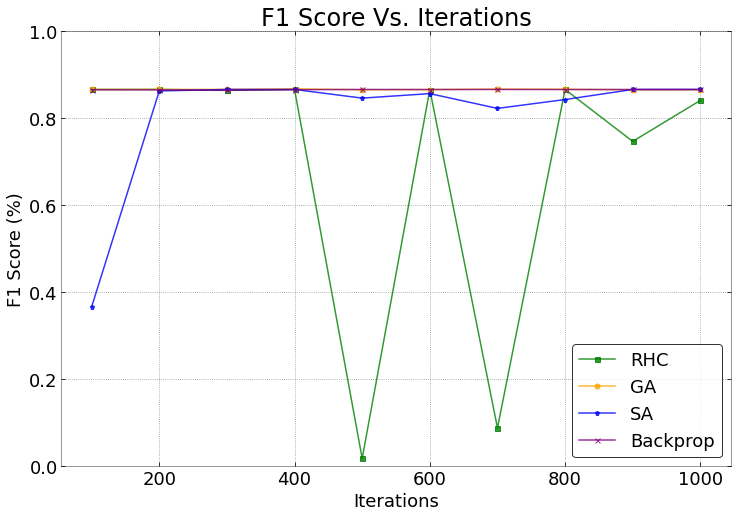

In [18]:
df = pd.read_excel(r'C:\Users\sagni\Documents\Personal Files\CS7641\Assignment2\NN_Images\F1_score.xlsx', engine='openpyxl')
header = 24
other_title = 18

#Plot RHC Train vs Test
plt.clf()
plt.figure(figsize=(12, 8))
plt.gcf().set_facecolor('white')
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor('white')
ax.set_facecolor('white')
plt.plot(df[['Itterations']], df[['random_hill_climb']], color='green', marker='s', markersize=5, label='RHC', alpha=0.8)
plt.plot(df[['Itterations']], df[['genetic_alg']], color='orange', marker='o', markersize=5, label='GA', alpha=0.8)
plt.plot(df[['Itterations']], df[['simulated_annealing']], color='blue', marker='p', markersize=5, label='SA', alpha=0.8)
plt.plot(df[['Itterations']], df[['gradient_descent']], color='purple', marker='x', markersize=5, label='Backprop', alpha=0.8)
plt.xlabel('Iterations', fontsize=other_title)
plt.ylabel('F1 Score (%)', fontsize=other_title)
title = "F1 Score Vs. Iterations"
plt.title(title, fontsize=header)
plt.legend(loc='lower right', frameon=True, edgecolor='black', facecolor='white', fontsize=other_title)
plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=4)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
spine_alpha = 0.5
plt.gca().spines['top'].set_alpha(spine_alpha)
plt.gca().spines['bottom'].set_alpha(spine_alpha)
plt.gca().spines['left'].set_alpha(spine_alpha)
plt.gca().spines['right'].set_alpha(spine_alpha)
plt.grid(True, linestyle="dotted", alpha=0.45, color='black')
plt.xticks(fontsize=other_title)
plt.yticks(fontsize=other_title)
plt.ylim(0, 1)
h1 = 'C:/Users/sagni/Documents/Personal Files/CS7641/Assignment2/NN_Images/F1ScoreVsIterations.png'
plt.savefig(h1, dpi=600)
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

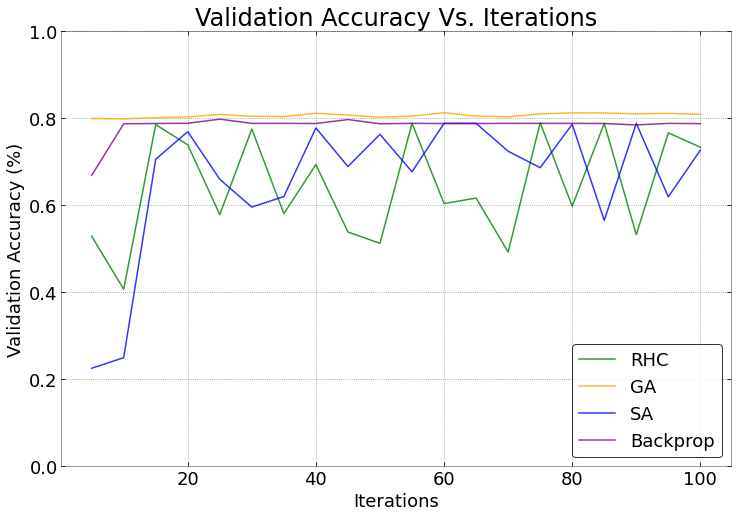

In [21]:
df = pd.read_excel(r'C:\Users\sagni\Documents\Personal Files\CS7641\Assignment2\NN_Images\Accuracy.xlsx', engine='openpyxl')
header = 24
other_title = 18

#Plot RHC Train vs Test
plt.clf()
plt.figure(figsize=(12, 8))
plt.gcf().set_facecolor('white')
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor('white')
ax.set_facecolor('white')
plt.plot(df[['iterations']], df[['RHC_Val']], color='green', label='RHC', alpha=0.8)
plt.plot(df[['iterations']], df[['GA_Val']], color='orange', label='GA', alpha=0.8)
plt.plot(df[['iterations']], df[['SA_Val']], color='blue', label='SA', alpha=0.8)
plt.plot(df[['iterations']], df[['GD_Val']], color='purple', label='Backprop', alpha=0.8)
plt.xlabel('Iterations', fontsize=other_title)
plt.ylabel('Validation Accuracy (%)', fontsize=other_title)
title = "Validation Accuracy Vs. Iterations"
plt.title(title, fontsize=header)
plt.legend(loc='lower right', frameon=True, edgecolor='black', facecolor='white', fontsize=other_title)
plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=4)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
spine_alpha = 0.5
plt.gca().spines['top'].set_alpha(spine_alpha)
plt.gca().spines['bottom'].set_alpha(spine_alpha)
plt.gca().spines['left'].set_alpha(spine_alpha)
plt.gca().spines['right'].set_alpha(spine_alpha)
plt.grid(True, linestyle="dotted", alpha=0.45, color='black')
plt.xticks(fontsize=other_title)
plt.yticks(fontsize=other_title)
plt.ylim(0, 1)
h1 = 'C:/Users/sagni/Documents/Personal Files/CS7641/Assignment2/NN_Images/ValAccuracyVsIterations.png'
plt.savefig(h1, dpi=600)
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

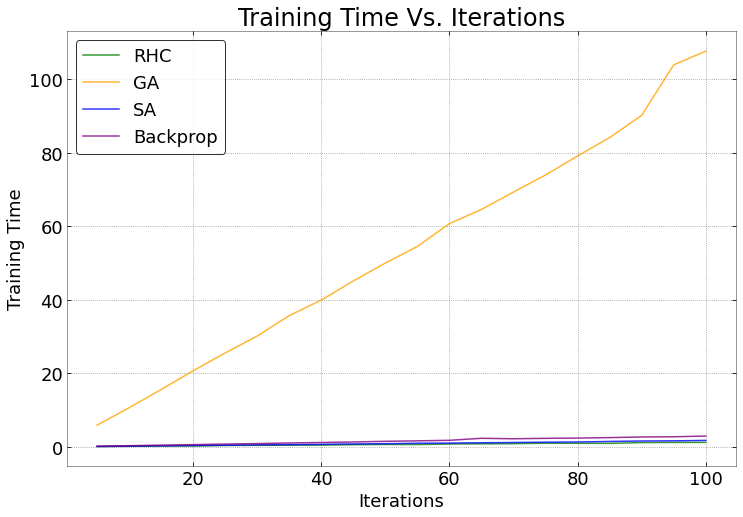

In [25]:
df = pd.read_excel(r'C:\Users\sagni\Documents\Personal Files\CS7641\Assignment2\NN_Images\Accuracy.xlsx', engine='openpyxl')
header = 24
other_title = 18

#Plot RHC Train vs Test
plt.clf()
plt.figure(figsize=(12, 8))
plt.gcf().set_facecolor('white')
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor('white')
ax.set_facecolor('white')
plt.plot(df[['iterations']], df[['RHC_Time']], color='green', label='RHC', alpha=0.8)
plt.plot(df[['iterations']], df[['GA_Time']], color='orange', label='GA', alpha=0.8)
plt.plot(df[['iterations']], df[['SA_Time']], color='blue', label='SA', alpha=0.8)
plt.plot(df[['iterations']], df[['GD_Time']], color='purple', label='Backprop', alpha=0.8)
plt.xlabel('Iterations', fontsize=other_title)
plt.ylabel('Training Time', fontsize=other_title)
title = "Training Time Vs. Iterations"
plt.title(title, fontsize=header)
plt.legend(loc='upper left', frameon=True, edgecolor='black', facecolor='white', fontsize=other_title)
plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=4)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
spine_alpha = 0.5
plt.gca().spines['top'].set_alpha(spine_alpha)
plt.gca().spines['bottom'].set_alpha(spine_alpha)
plt.gca().spines['left'].set_alpha(spine_alpha)
plt.gca().spines['right'].set_alpha(spine_alpha)
plt.grid(True, linestyle="dotted", alpha=0.45, color='black')
plt.xticks(fontsize=other_title)
plt.yticks(fontsize=other_title)
h1 = 'C:/Users/sagni/Documents/Personal Files/CS7641/Assignment2/NN_Images/TrainingTimeVsIterations.png'
plt.savefig(h1, dpi=600)
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

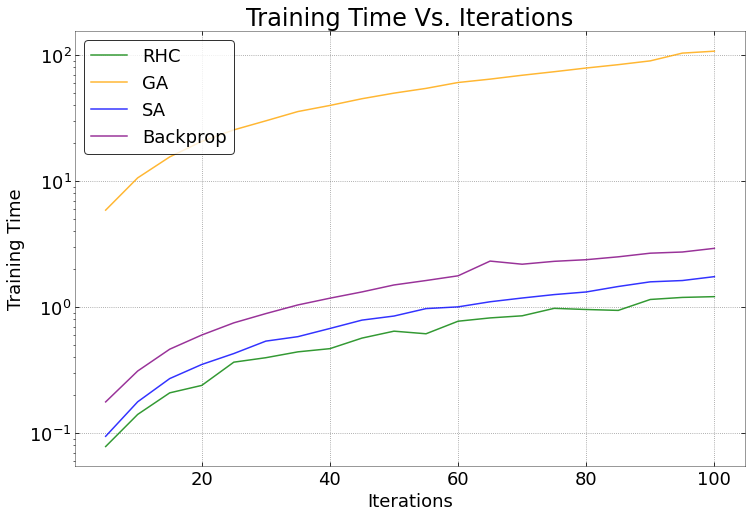

In [3]:
df = pd.read_excel(r'C:\Users\sagni\Documents\Personal Files\CS7641\Assignment2\NN_Images\Accuracy.xlsx', engine='openpyxl')
header = 24
other_title = 18

#Plot RHC Train vs Test
plt.clf()
plt.figure(figsize=(12, 8))
plt.gcf().set_facecolor('white')
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor('white')
ax.set_facecolor('white')
plt.plot(df[['iterations']], df[['RHC_Time']], color='green', label='RHC', alpha=0.8)
plt.plot(df[['iterations']], df[['GA_Time']], color='orange', label='GA', alpha=0.8)
plt.plot(df[['iterations']], df[['SA_Time']], color='blue', label='SA', alpha=0.8)
plt.plot(df[['iterations']], df[['GD_Time']], color='purple', label='Backprop', alpha=0.8)
plt.xlabel('Iterations', fontsize=other_title)
plt.ylabel('Training Time', fontsize=other_title)
title = "Training Time Vs. Iterations"
plt.title(title, fontsize=header)
plt.legend(loc='upper left', frameon=True, edgecolor='black', facecolor='white', fontsize=other_title)
plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True, length=4)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
spine_alpha = 0.5
plt.gca().spines['top'].set_alpha(spine_alpha)
plt.gca().spines['bottom'].set_alpha(spine_alpha)
plt.gca().spines['left'].set_alpha(spine_alpha)
plt.gca().spines['right'].set_alpha(spine_alpha)
plt.grid(True, linestyle="dotted", alpha=0.45, color='black')
plt.yscale('log')
plt.xticks(fontsize=other_title)
plt.yticks(fontsize=other_title)
h1 = 'C:/Users/sagni/Documents/Personal Files/CS7641/Assignment2/NN_Images/TrainingTimeVsIterations_log.png'
plt.savefig(h1, dpi=600)
plt.show()

In [16]:
def GA_tuneing(trainX, testX, trainY, testY):
    
    nn = NeuralNetwork(hidden_nodes=[32,], activation='relu',
                                   algorithm=algorithm, max_iters=int(max_iter),
                                   bias=True, is_classifier=True, learning_rate=0.001,
                                   early_stopping=False, clip_max=1e10, schedule=exp_decay,
                                   pop_size=kwargs['pop_size'], mutation_prob=kwargs['mutation_prob'],
                                   max_attempts=int(max_iter), random_state=random_seed, curve=True)

TypeError: fit() got an unexpected keyword argument 'curve'